In [1]:
import matplotlib.pyplot as plt
import warnings
import yfinance
import pandas as pd
import numpy as np
import datetime
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore')

In [2]:
df_yahoo=yfinance.download('AAPL',start="2020-01-01",end="2022-01-01",progress=False)
df=df_yahoo.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))
df.dropna(how = 'any', inplace = True)
display(df)

,adj_close,simple_rtn,log_rtn
Date,,,
2020-01-03,72.967216,-0.009722,-0.009770
2020-01-06,73.548622,0.007968,0.007936
2020-01-07,73.202728,-0.004703,-0.004714
2020-01-08,74.380295,0.016086,0.015958
2020-01-09,75.960190,0.021241,0.021018
...,...,...,...
2021-12-27,179.586868,0.022975,0.022715
2021-12-28,178.551132,-0.005767,-0.005784
2021-12-29,178.640778,0.000502,0.000502


In [3]:
df_test=df[len(df)-10:]
df_train=df[:len(df)-10]

[Text(0.5, 1.0, 'AAPL time series'), Text(0, 0.5, 'simple rtn')]

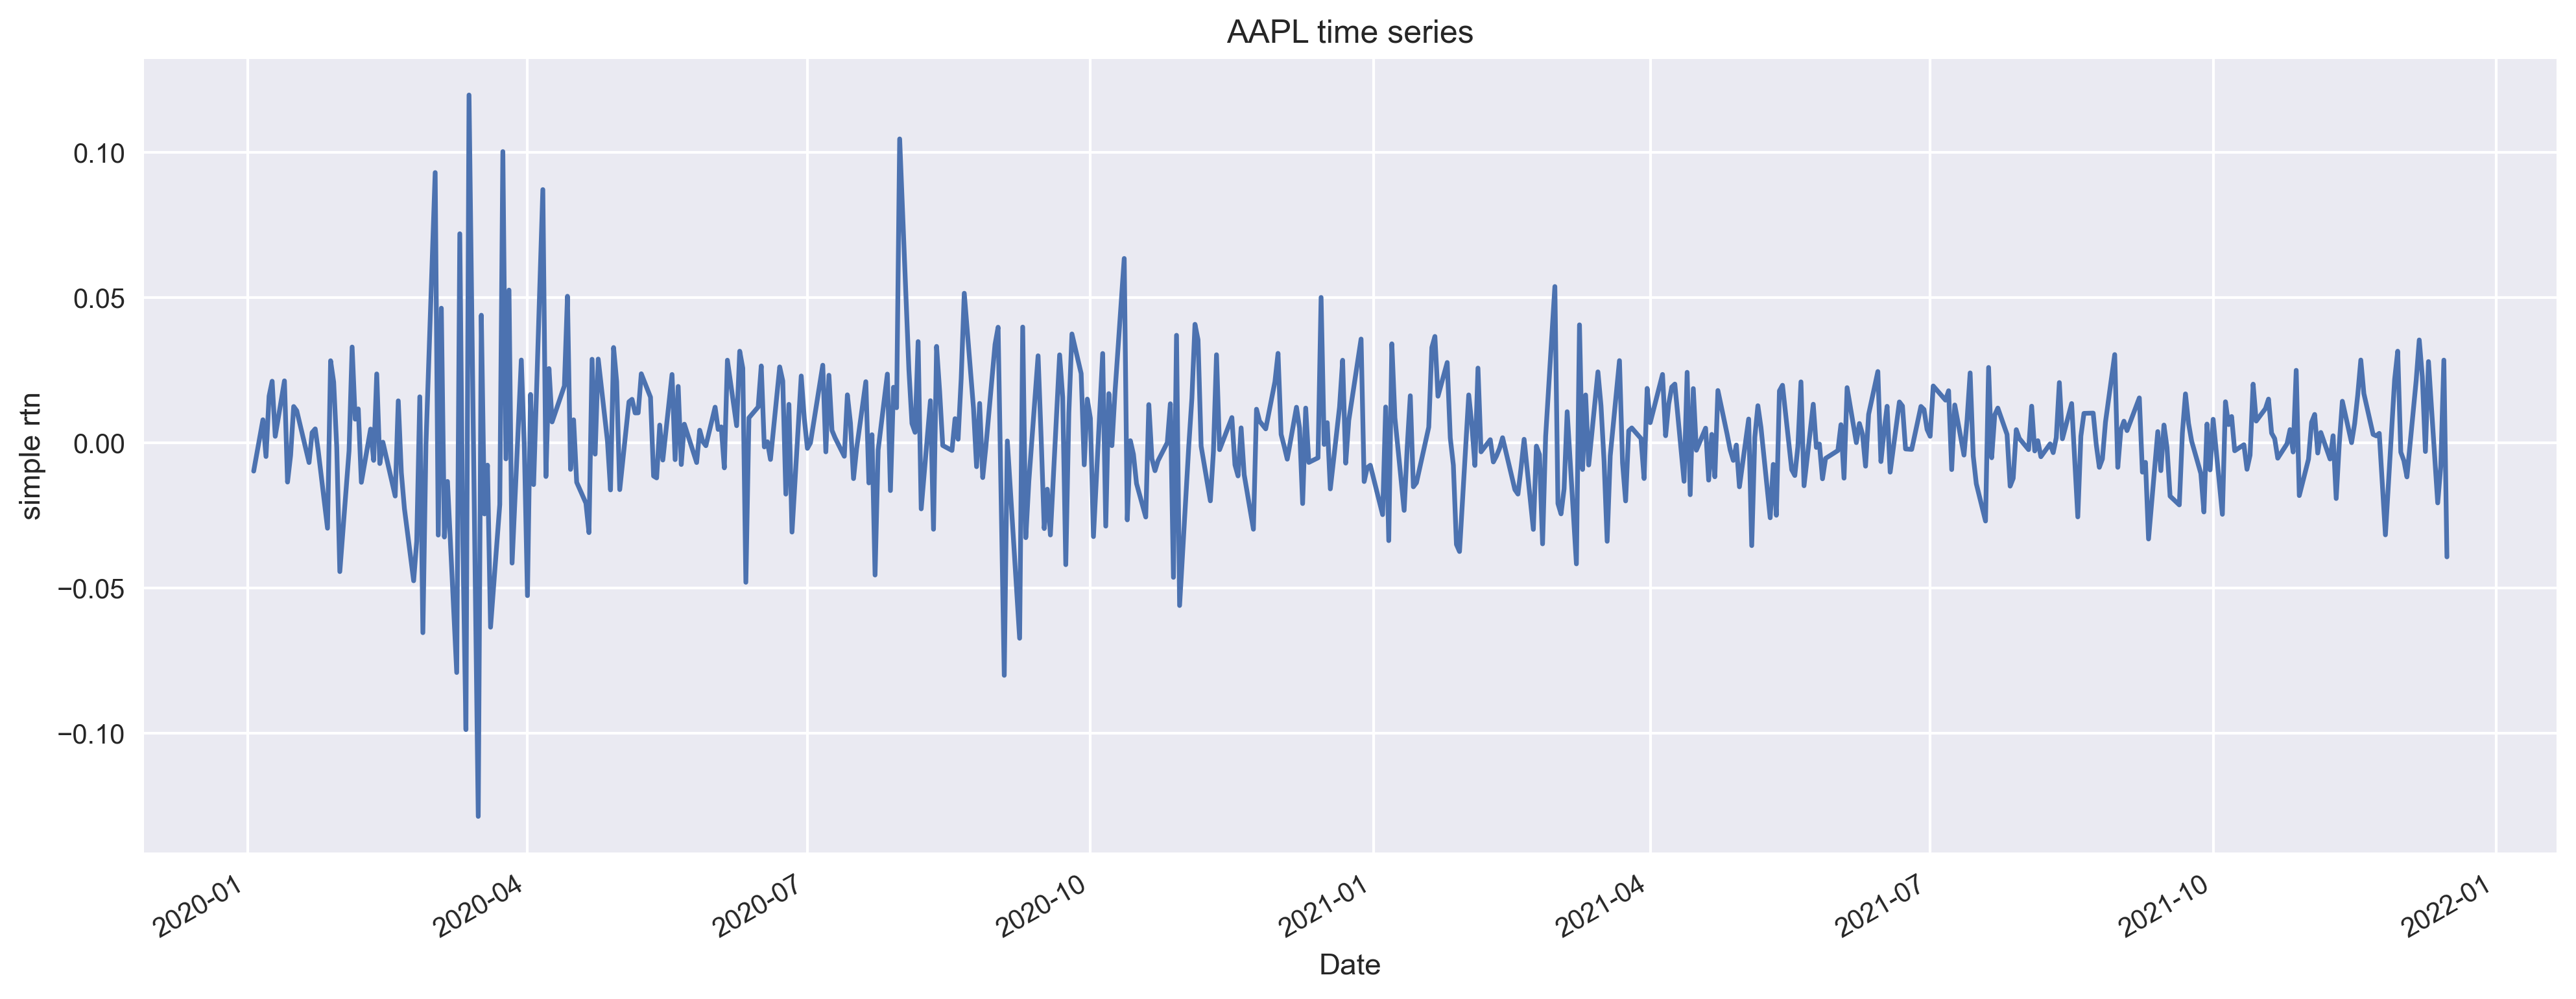

In [4]:
fig,ax = plt.subplots(1, 1, figsize=(16, 6), sharex=True)
df_train.simple_rtn.plot(ax=ax)
ax.set(title = 'AAPL time series', ylabel = 'simple rtn')  

In [5]:
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa import stattools
from arch.unitroot import ADF

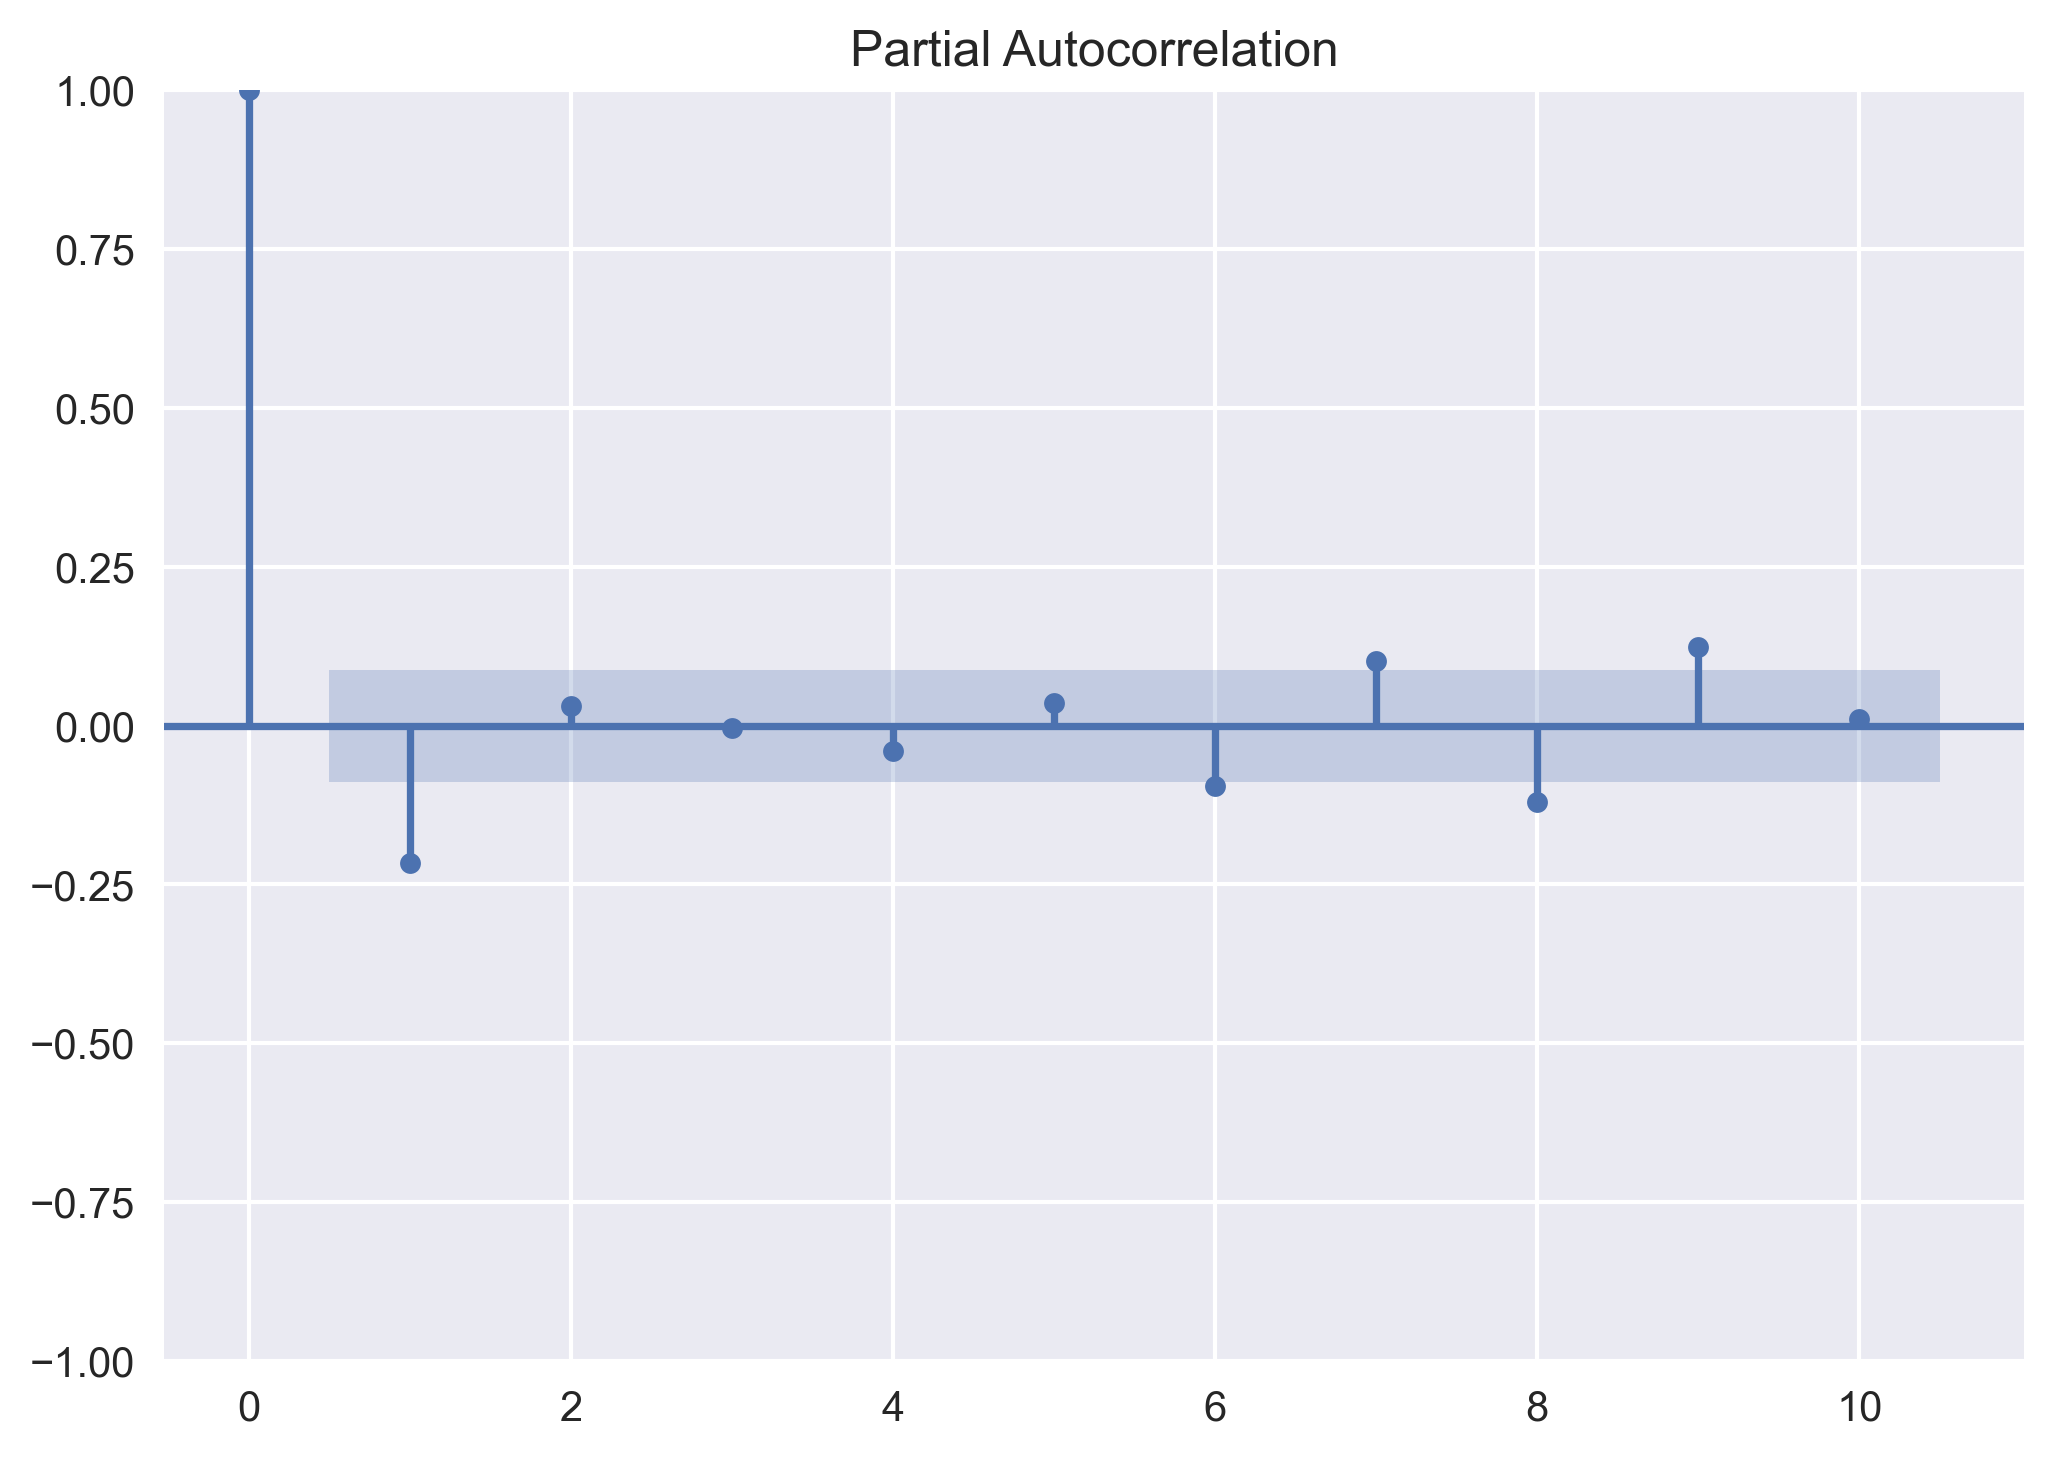

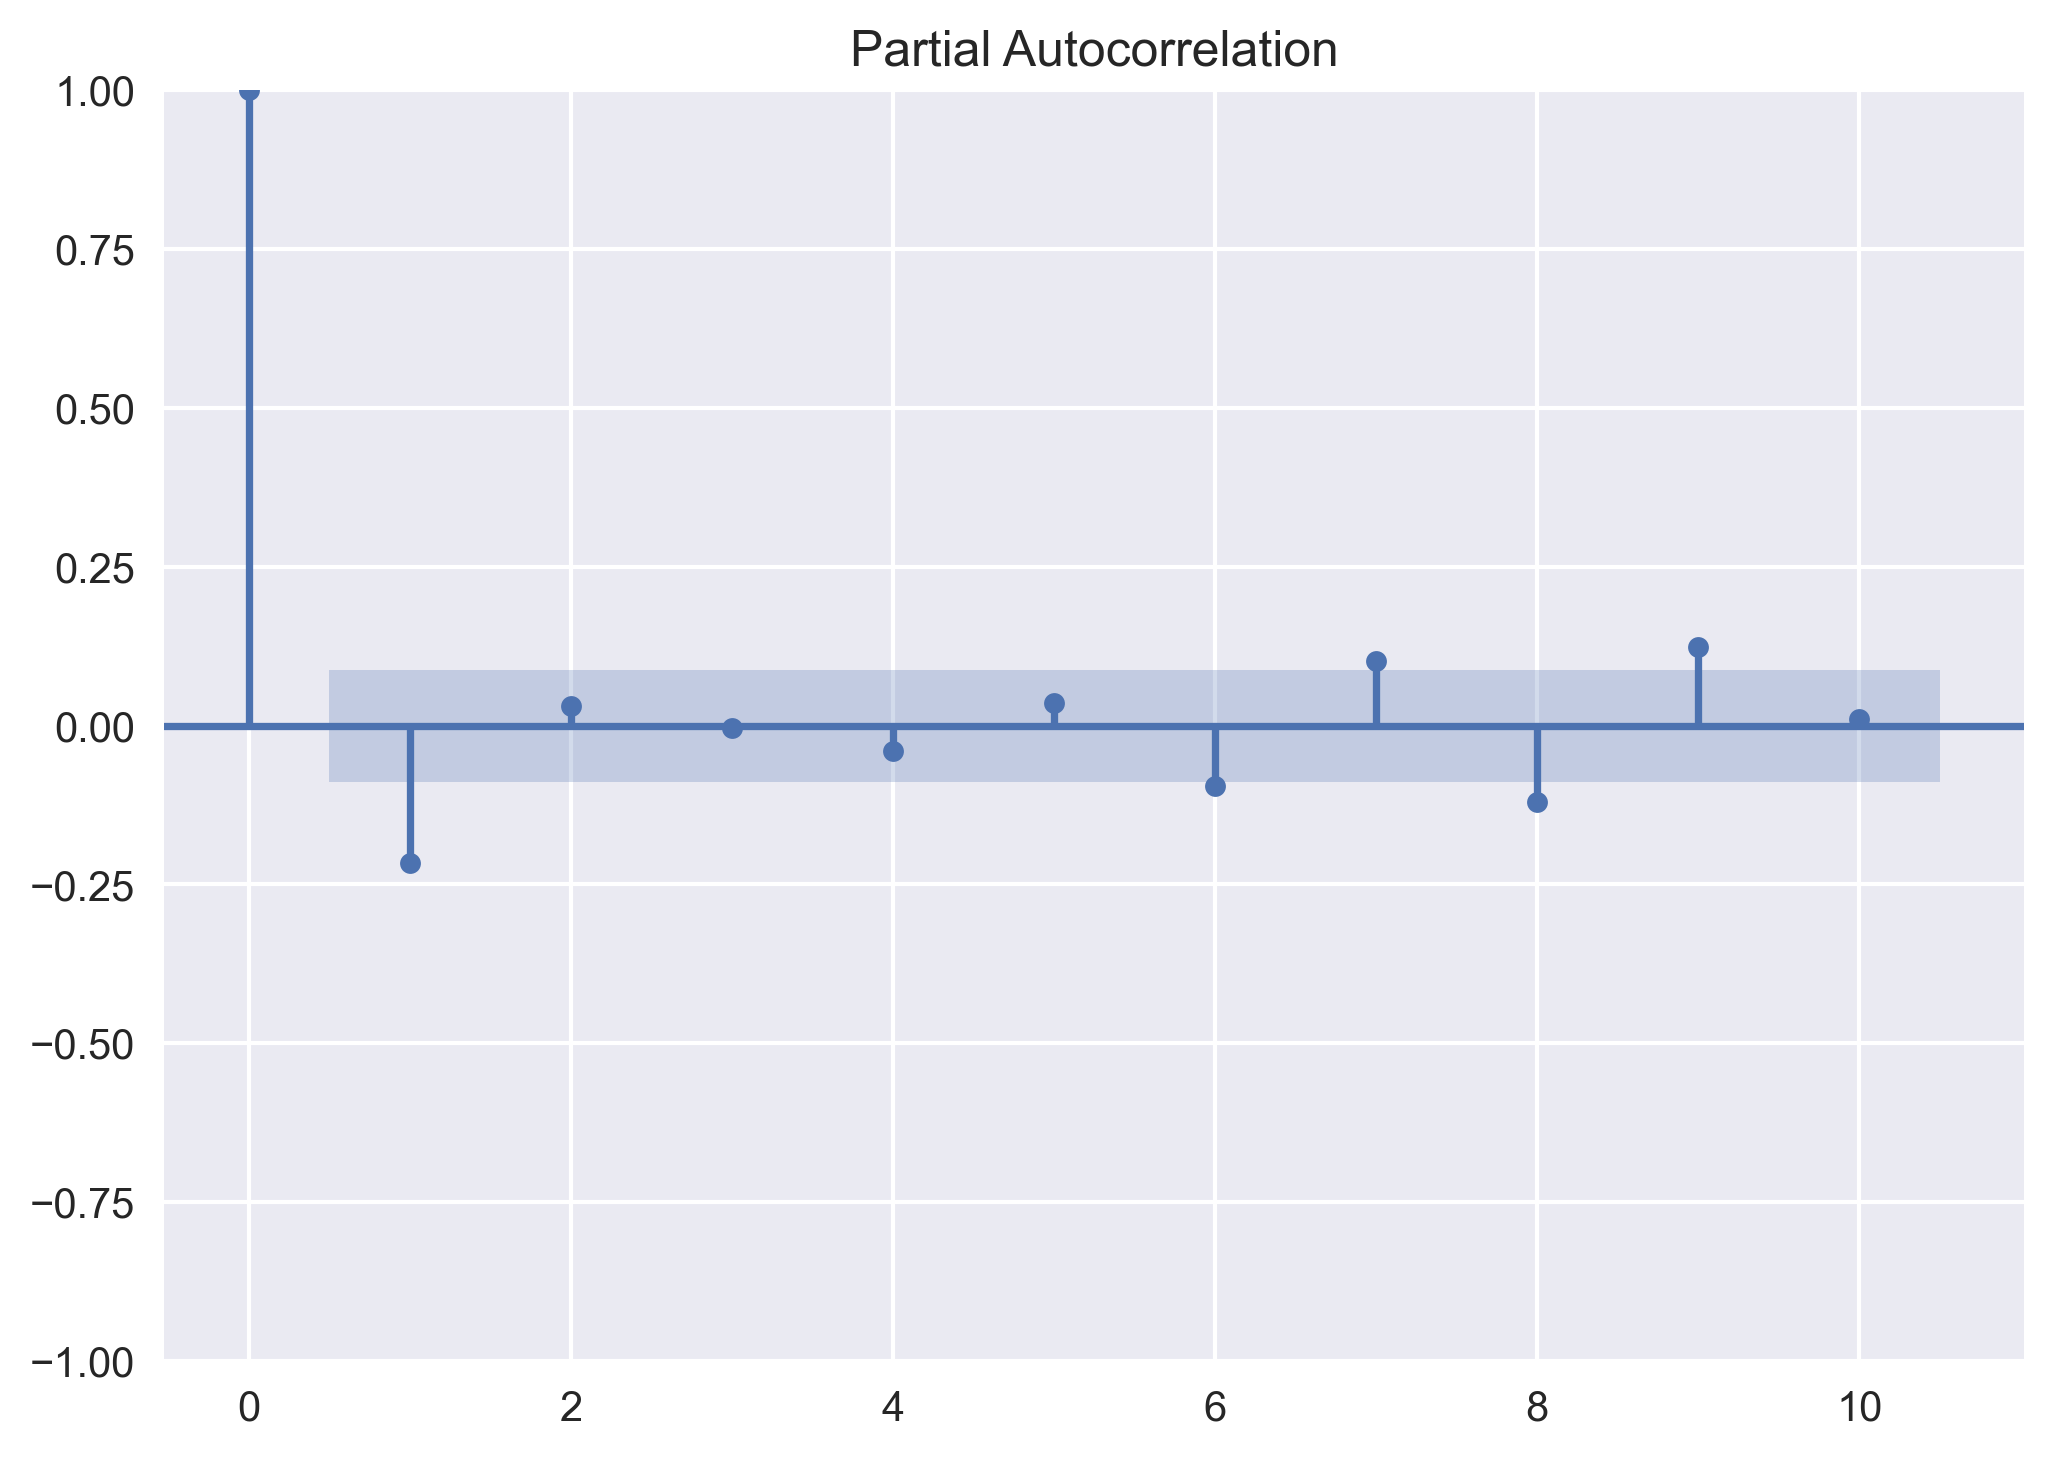

In [7]:
plot_pacf(df_train.simple_rtn,use_vlines=True,lags=10)

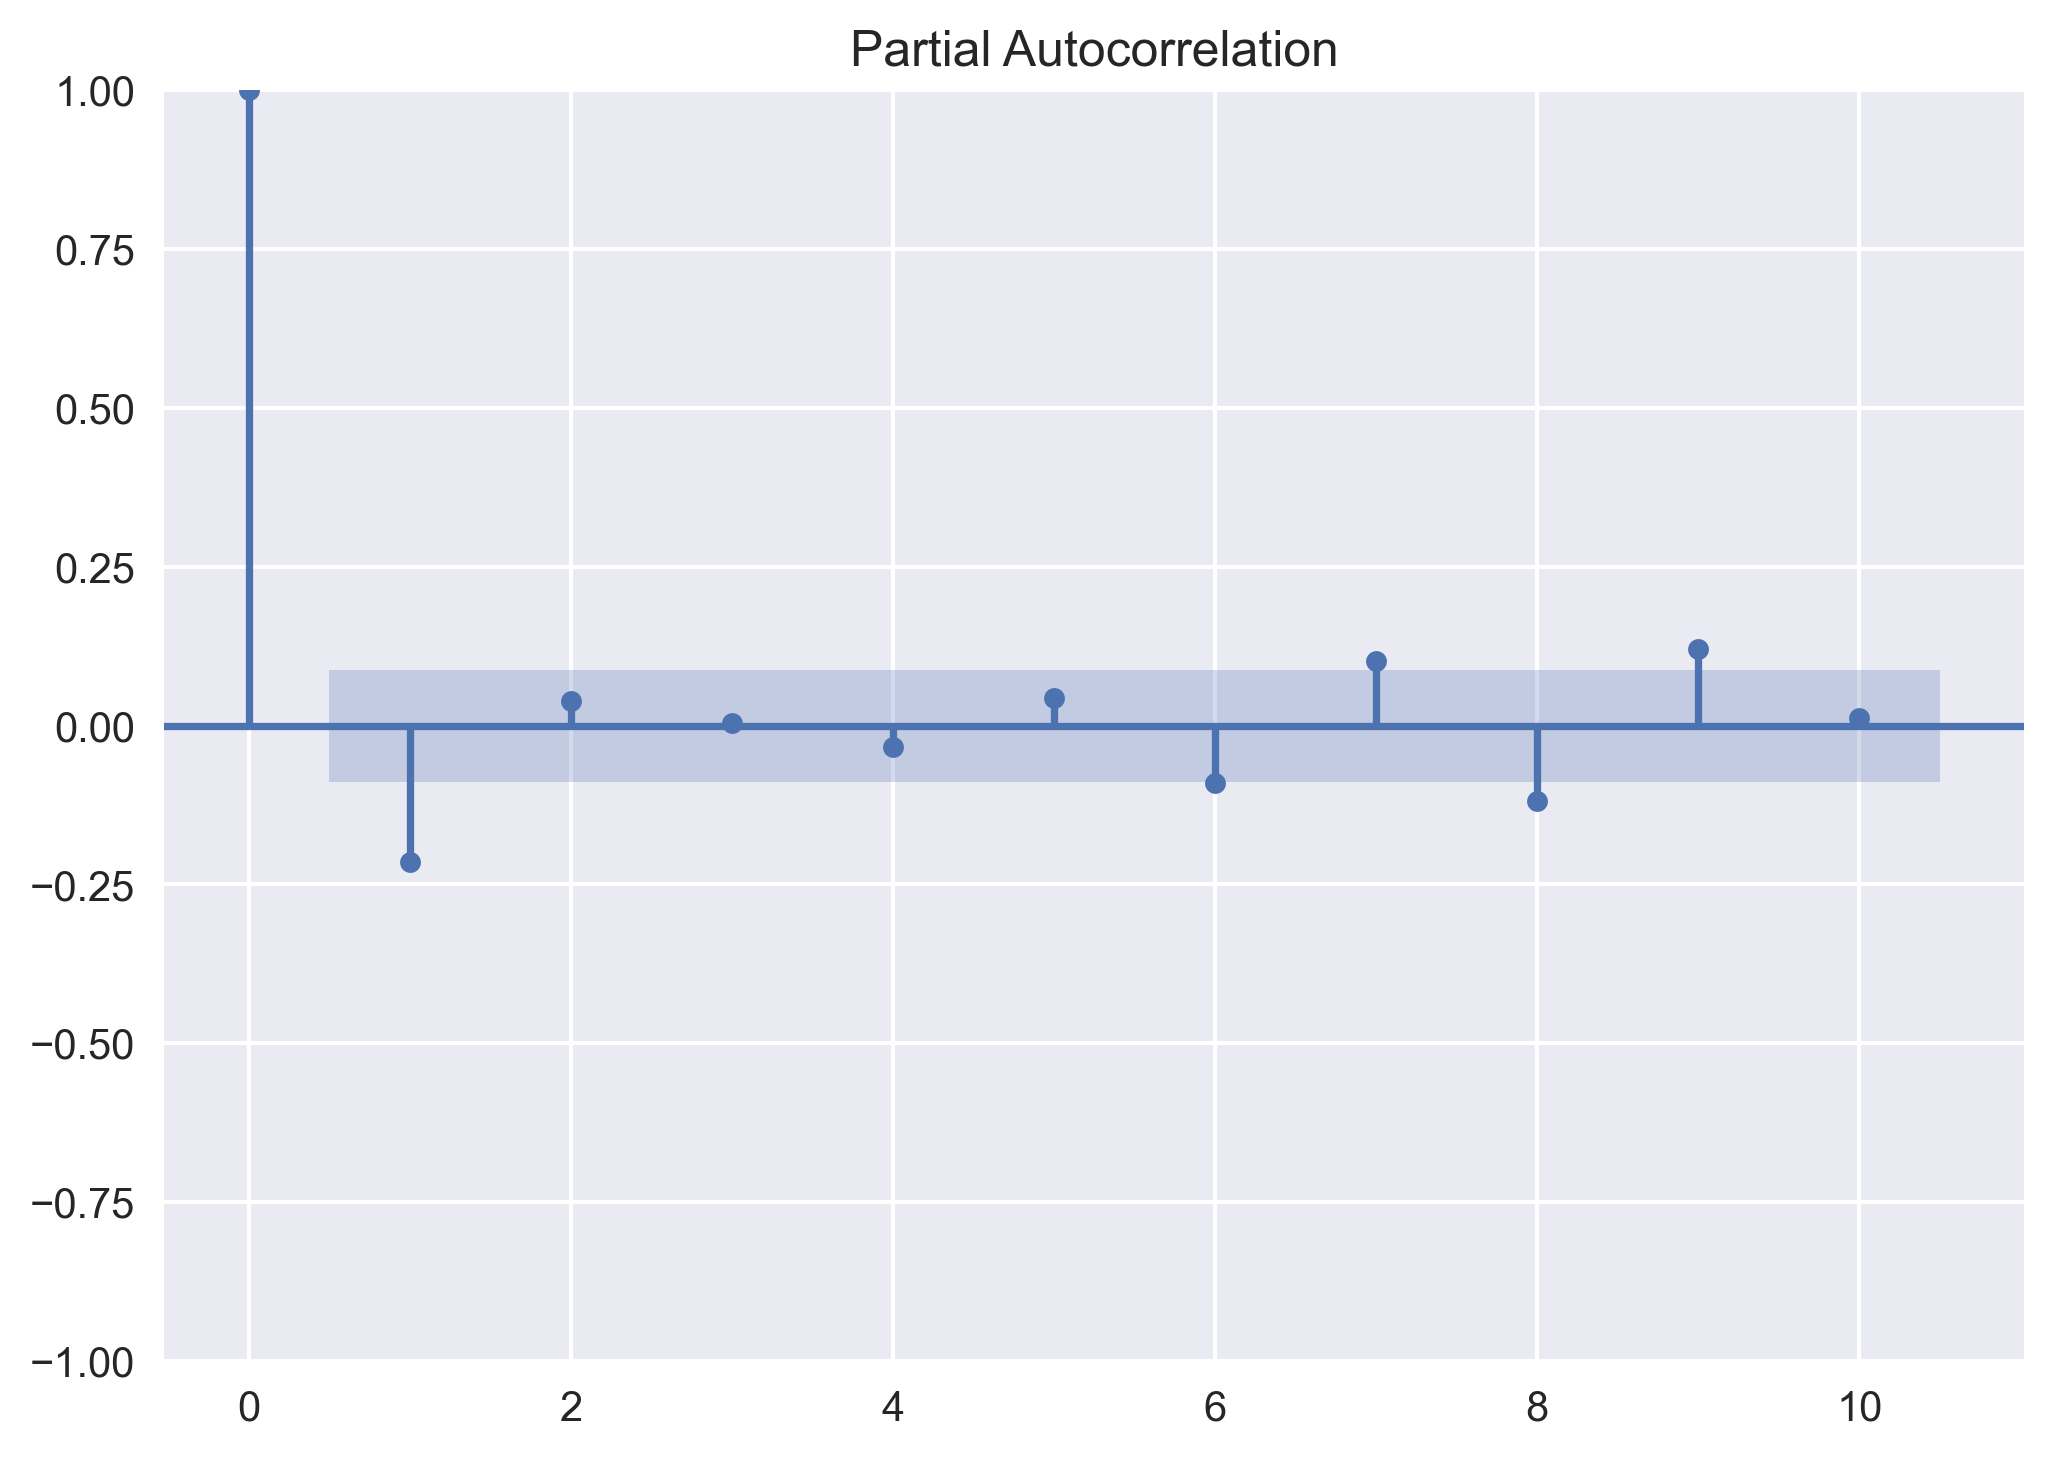

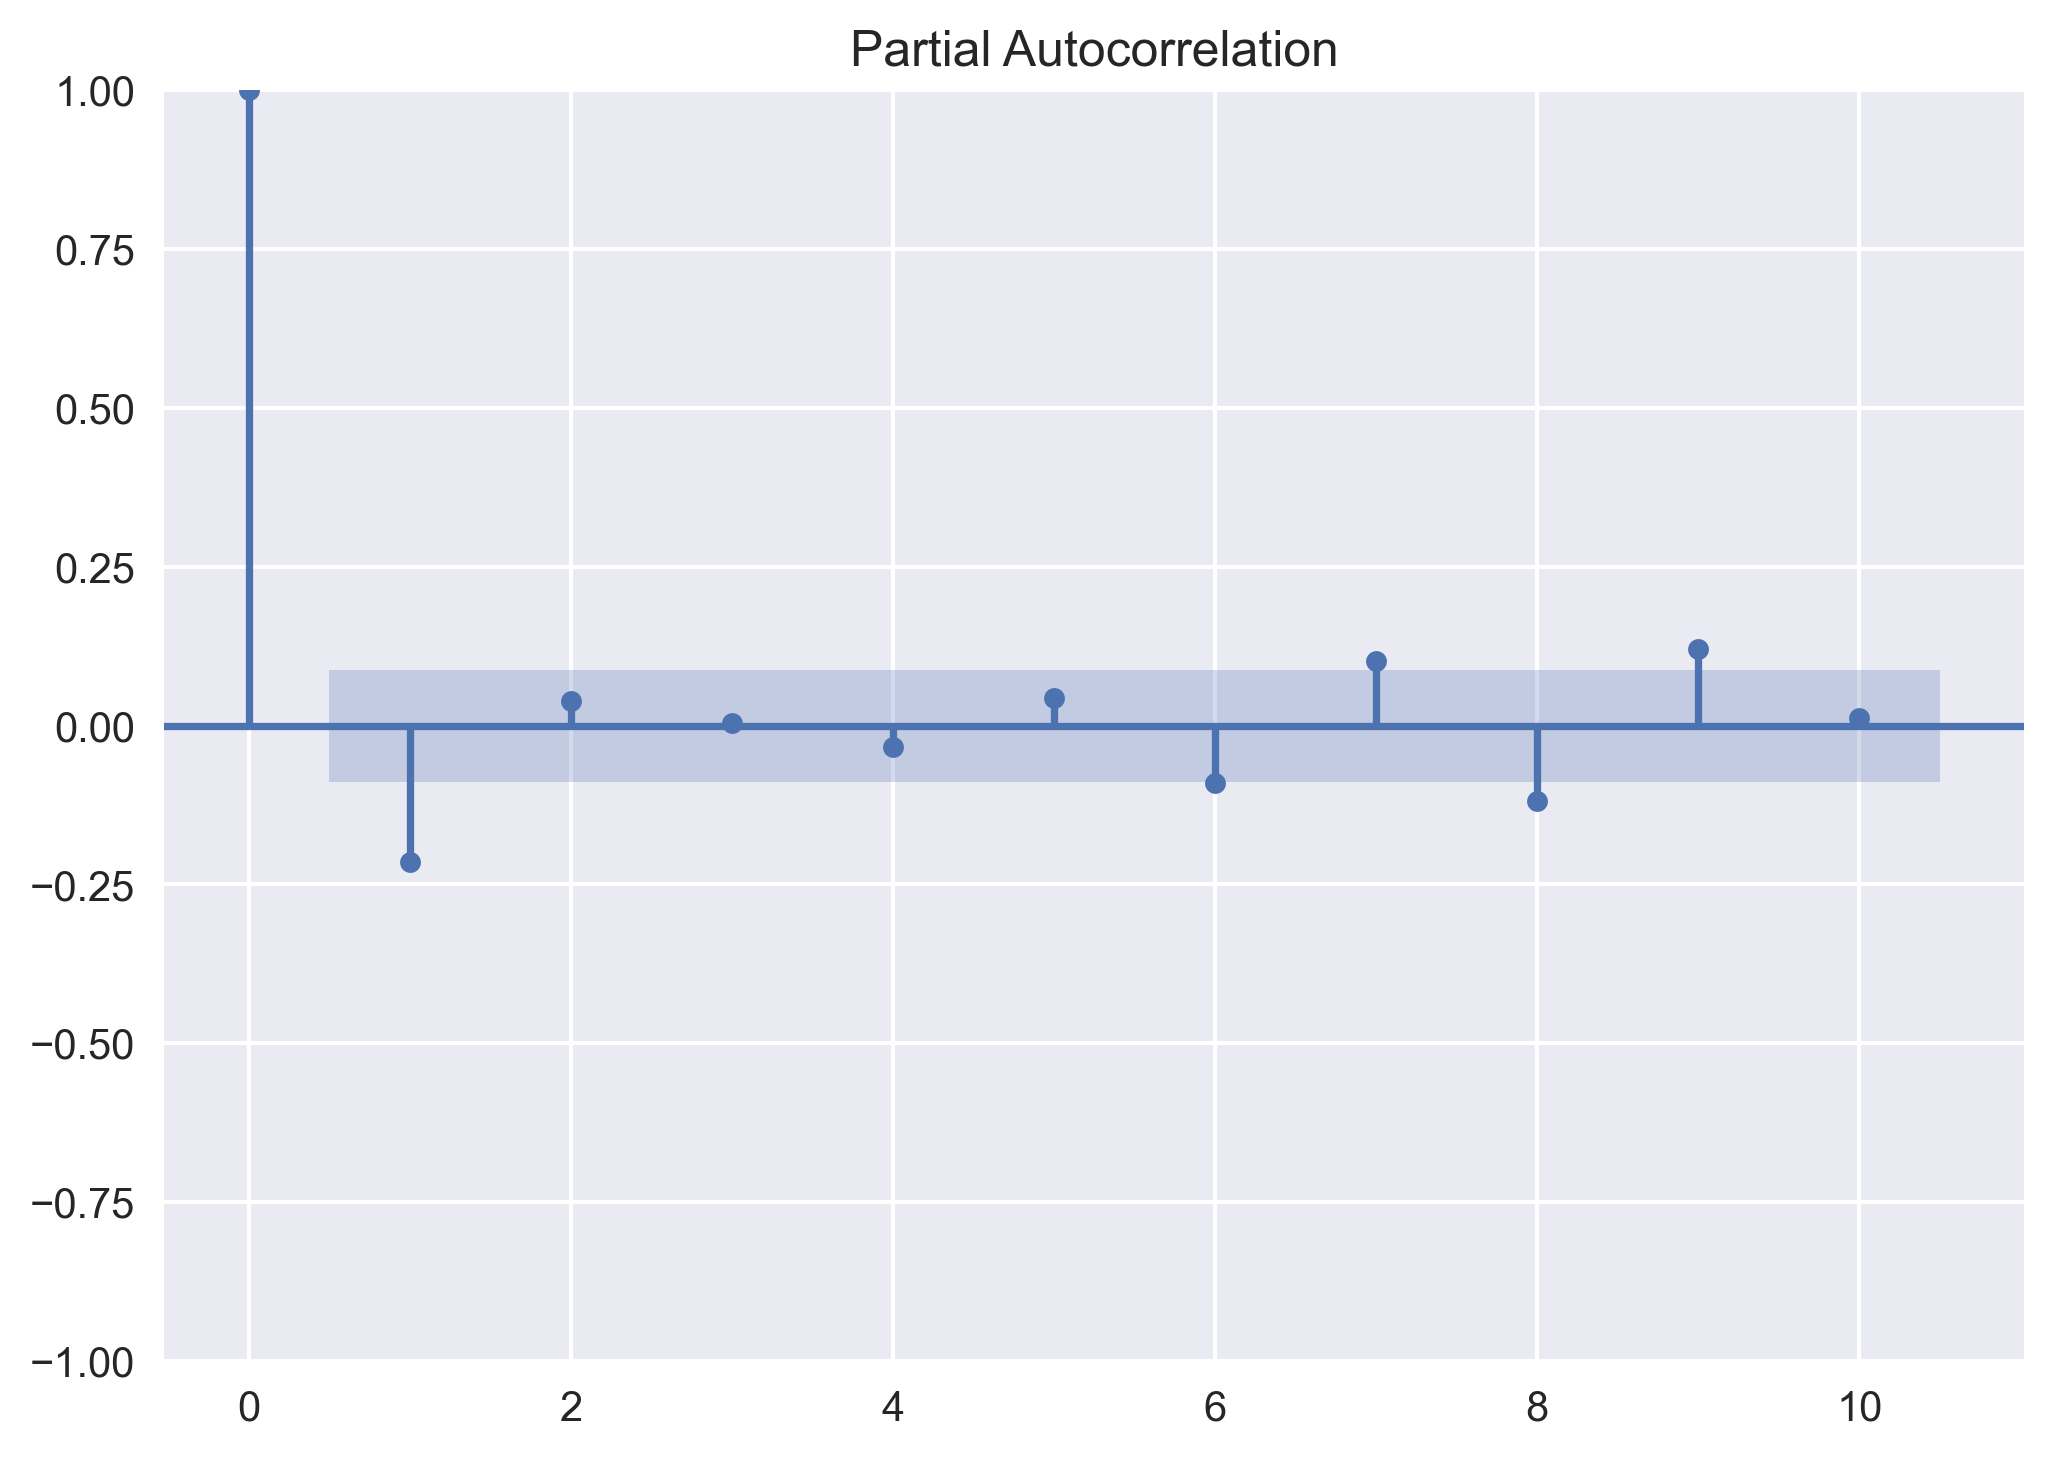

In [8]:
plot_pacf(df_train.log_rtn,use_vlines=True,lags=10)

In [9]:
adfaapl=ADF(df_train.adj_close,method='aic')
print(adfaapl.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.320
P-value                         0.923
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


<AxesSubplot:xlabel='Date'>

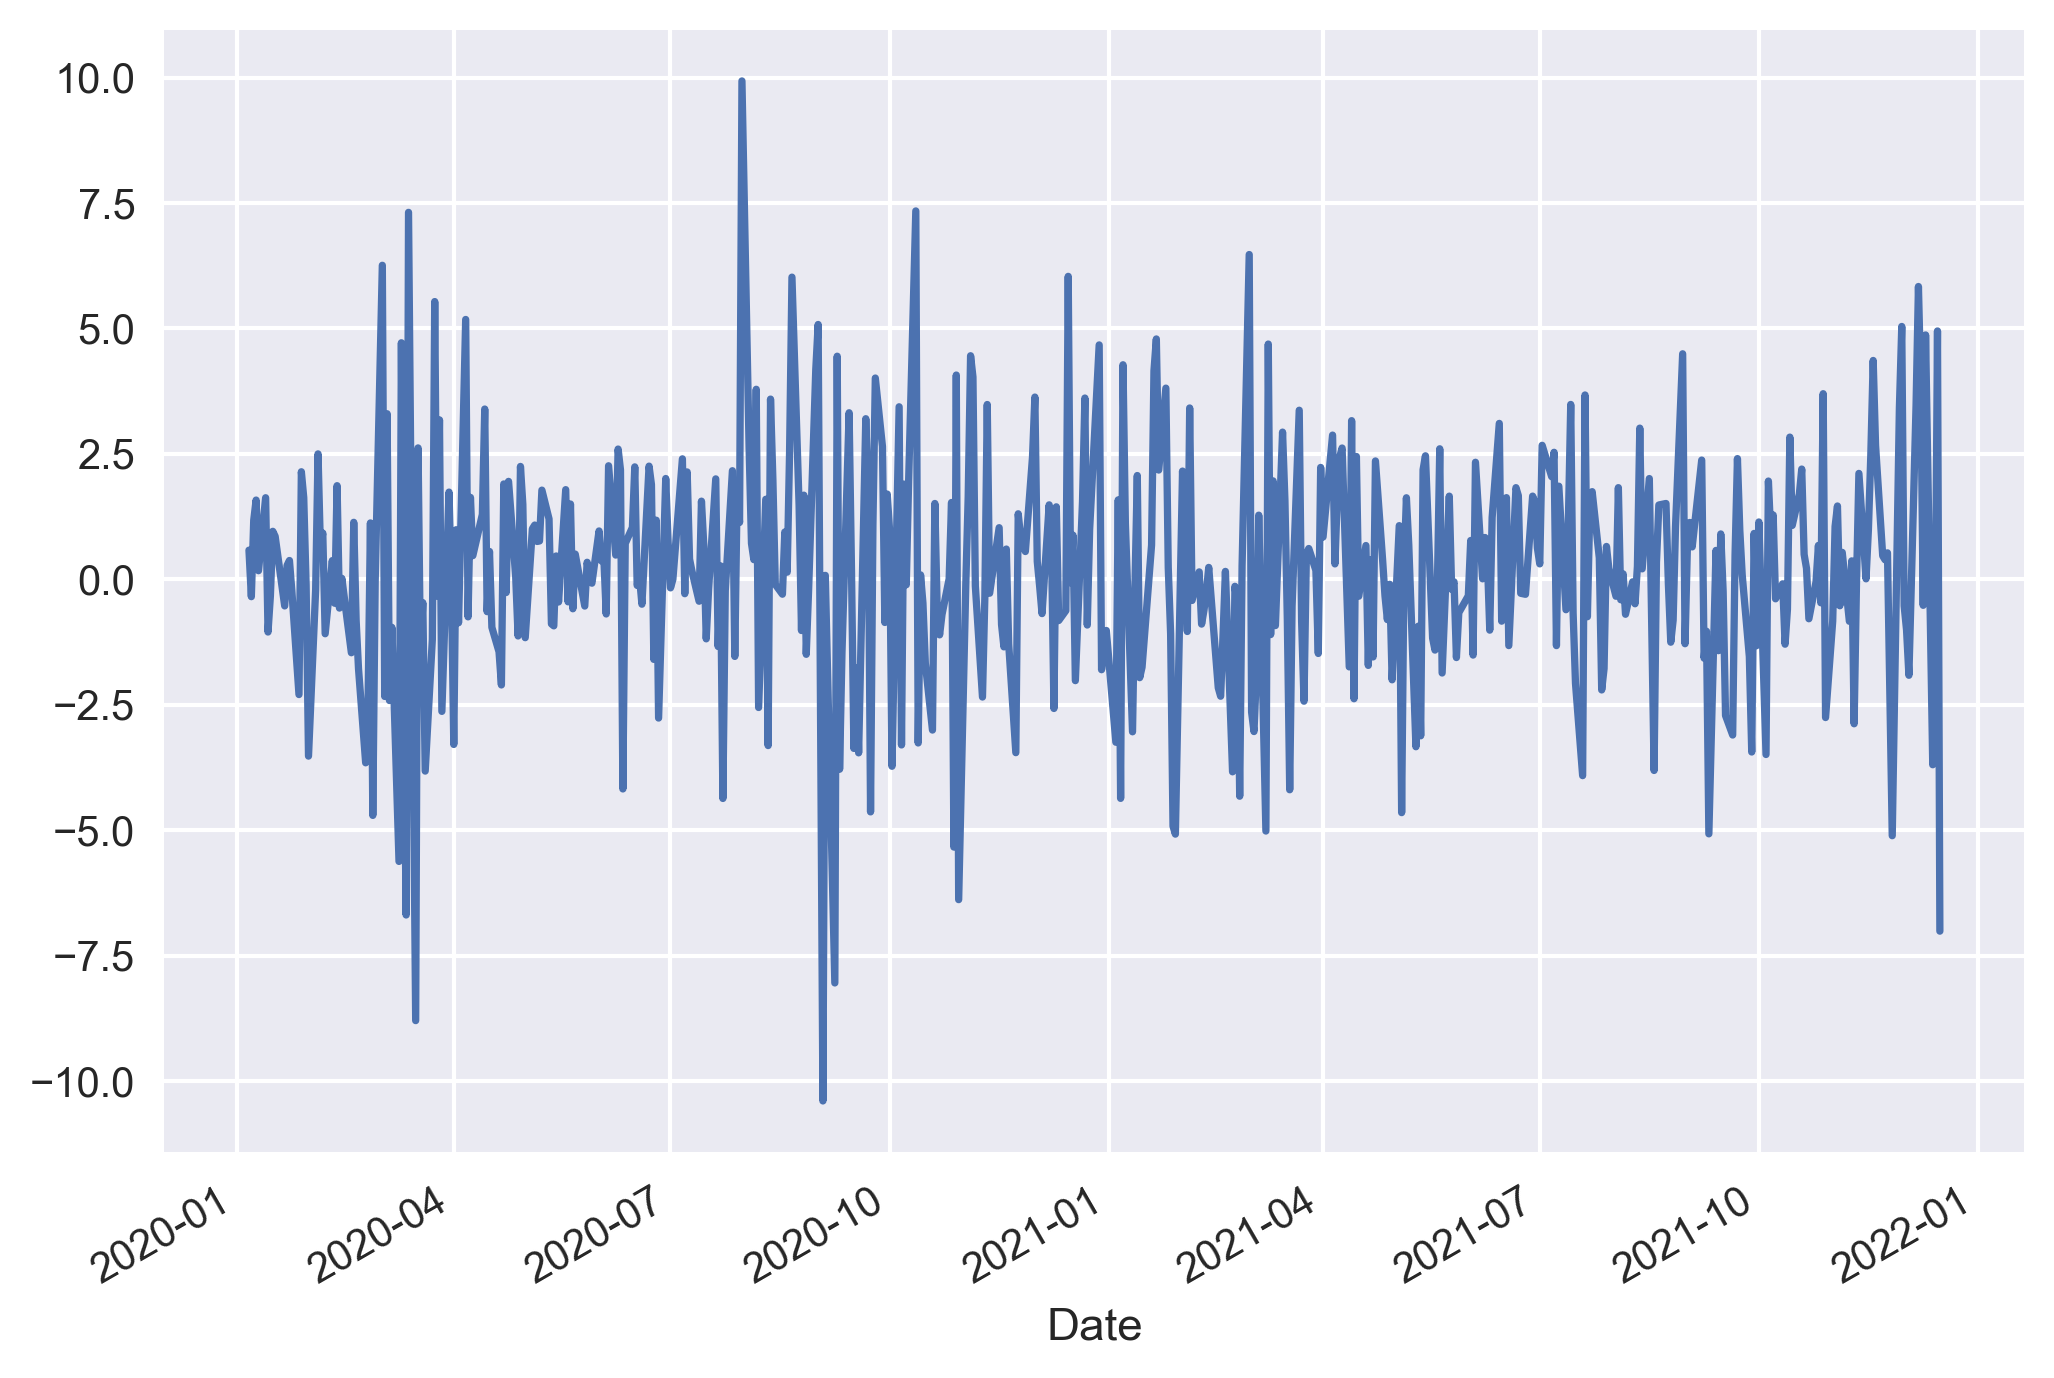

In [12]:
D_ts=df_train.adj_close.diff().dropna()#first difference
D_ts.columns = [u'adj_close_d']
D_ts.plot()

In [13]:
adfaapl=ADF(D_ts,method='aic',max_lags=30)
print(adfaapl.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -24.724
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


<AxesSubplot:xlabel='Date'>

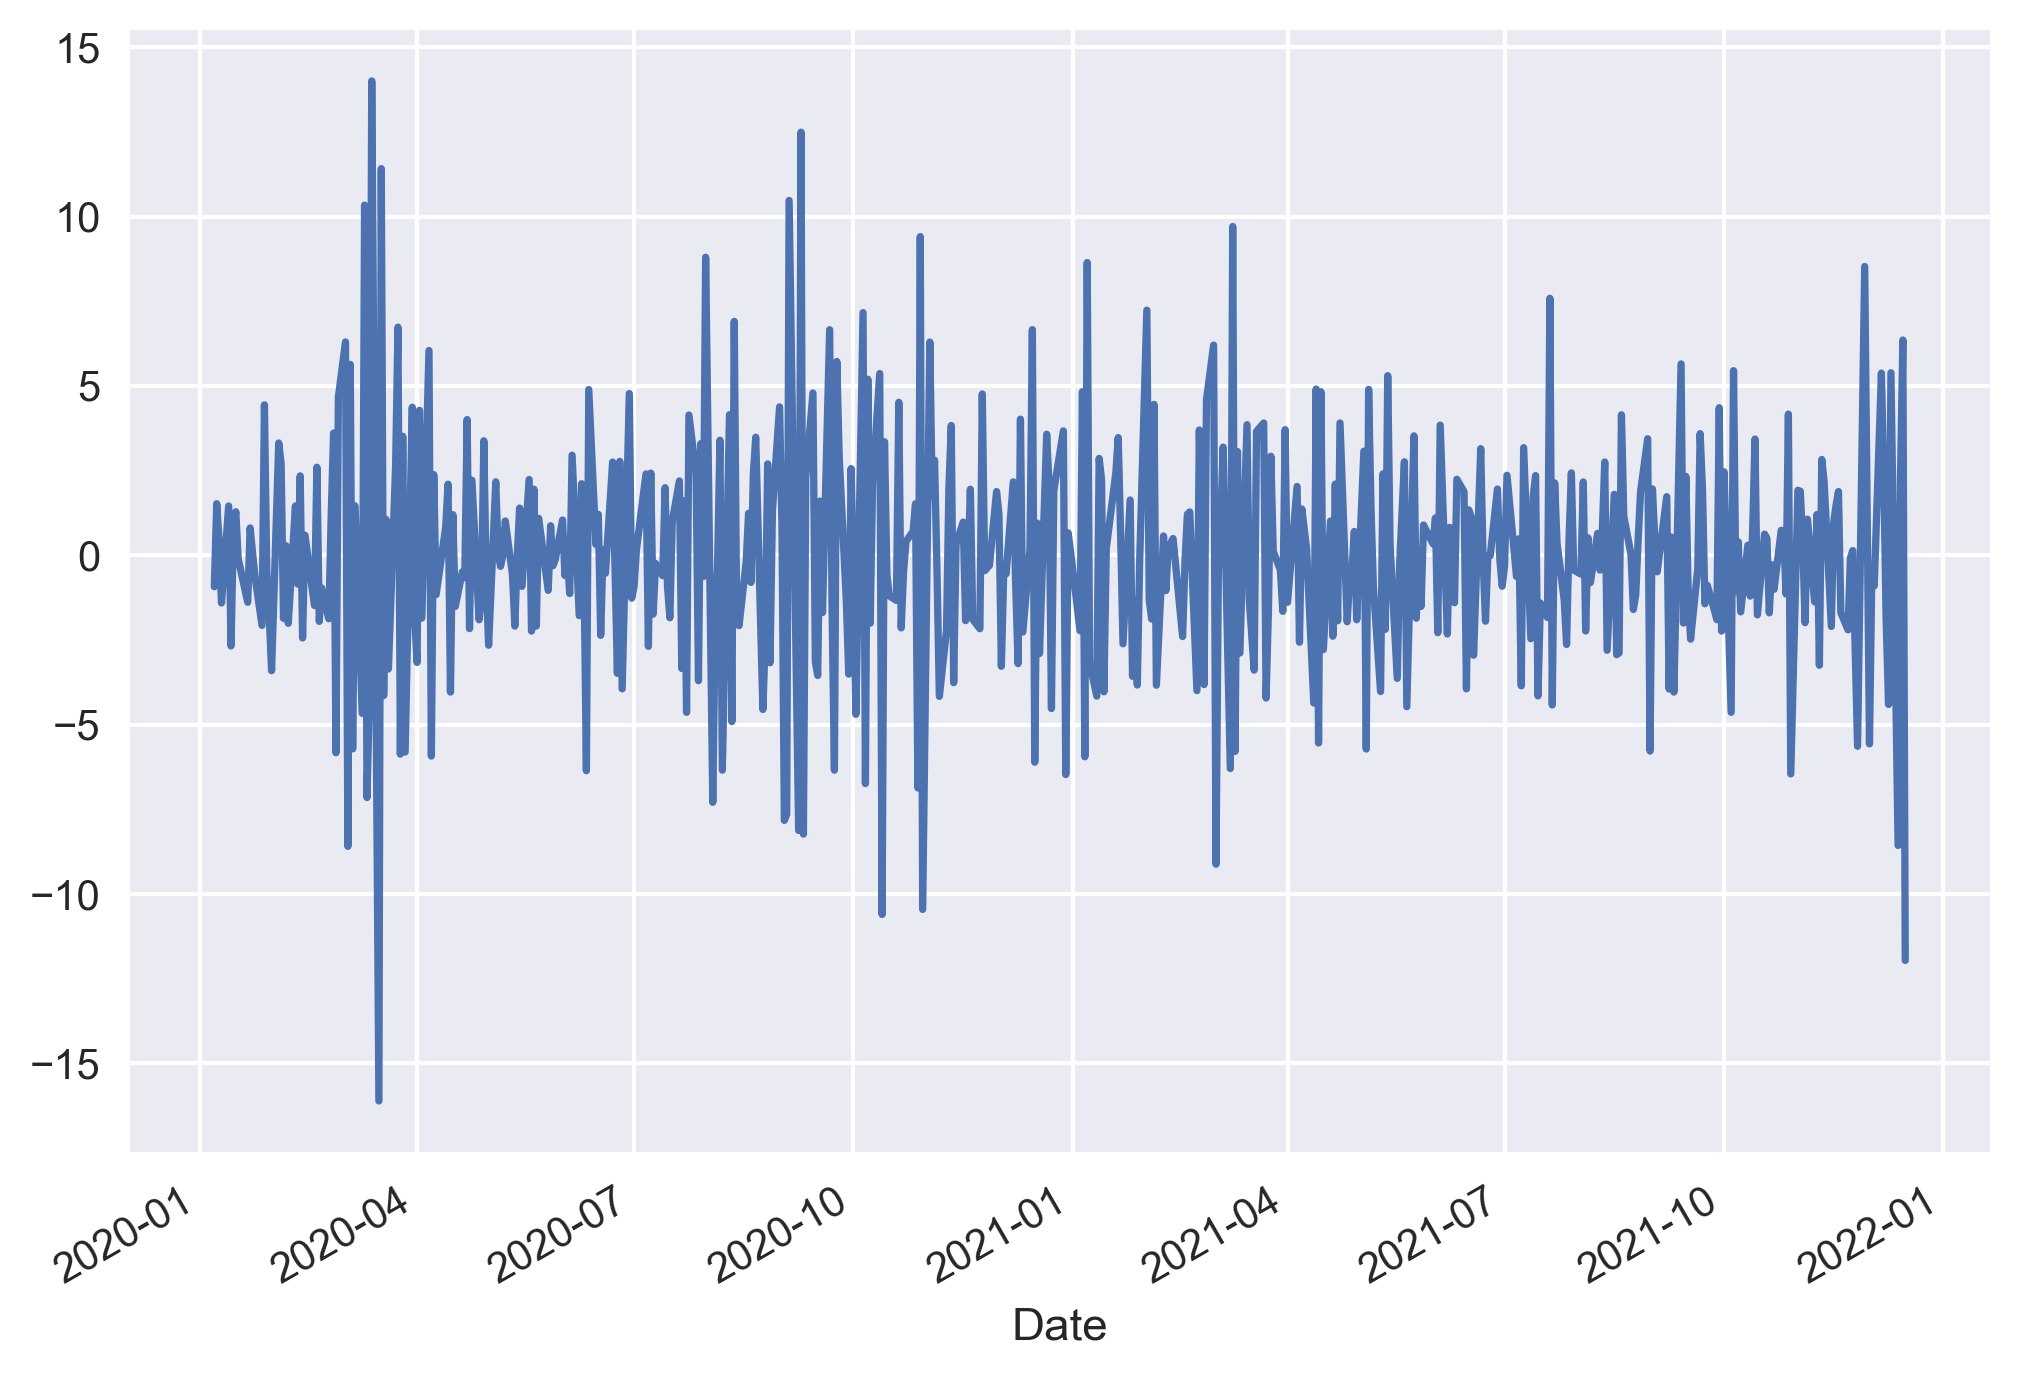

In [15]:
D_ts=D_ts.diff().dropna()#first difference
D_ts.columns = [u'adj_close_d']
D_ts.plot()

In [16]:
Lj=stattools.q_stat(stattools.acf(D_ts)[1:12],len(D_ts))

if Lj[1][-1]>0.05:
    (print('White Noise'))
else:
    (print(Lj[1][-1],'<0.05','\n'' NOT White Noise and you can go on'))

7.318460716771682e-32 <0.05 
 NOT White Noise and you can go on


In [17]:
from statsmodels.tsa import arima_model
x=stattools.arma_order_select_ic(D_ts,max_ma=10,ic='aic')

c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Conve

In [24]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(D_ts,order=(x['aic_min_order'][0],1,x['aic_min_order'][1])).fit()
model.summary()

c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  492
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1135.019
Date:                Fri, 28 Oct 2022   AIC                           2282.039
Time:                        19:33:31   BIC                           2307.217
Sample:                             0   HQIC                          2291.926
                                - 492                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1169      2.015     -0.554      0.579      -5.066       2.833
ar.L2         -0.1170      0.235     -0.498      0.618      -0.577       0.343
ma.L1         -0.9998    219.721     -0.005      0.996    -431.646     429.646
ma.L2         -1.0000    227.609     -0.004      0.996    -447.105     445.105
ma.L3          0.9998      7.932      0.126      0.900     -14.546      16.546
sigma2         5.6825     33.580      0.169      0.866     -60.133      71.498
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                94.06
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.16
Prob(H) (two-sided):                  0.27   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.99e+18. Standard errors may be unstable.
"""

In [25]:
model.conf_int()

,0,1
ar.L1,-5.066362,2.832509
ar.L2,-0.577346,0.343405
ma.L1,-431.645827,429.646243
ma.L2,-447.104954,445.104956
ma.L3,-14.546061,16.545643
sigma2,-60.132872,71.497944


In [28]:
pred_diff=model.forecast(df_test.shape[0])
pred_diff

c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


492    8.146111
493   -0.948689
494    0.107506
495   -0.008362
496   -0.002490
497    0.004504
498   -0.003995
499    0.004680
500   -0.004015
501    0.004682
Name: predicted_mean, dtype: float64

In [31]:
last = df_train.iloc[-1]['adj_close']
pred = []
for i in pred_diff:
    pred.append(last+i)
    last = last+i
df_test['pred'] = pred
df_test

,adj_close,simple_rtn,log_rtn,pred
Date,,,,
2021-12-17,170.434738,-0.006502,-0.006523,179.696206
2021-12-20,169.050446,-0.008122,-0.008155,178.747517
2021-12-21,172.277100,0.019087,0.018907,178.855023
2021-12-22,174.916183,0.015319,0.015203,178.846661
2021-12-23,175.553543,0.003644,0.003637,178.844171
2021-12-27,179.586868,0.022975,0.022715,178.848675
2021-12-28,178.551132,-0.005767,-0.005784,178.844681
2021-12-29,178.640778,0.000502,0.000502,178.849360
2021-12-30,177.465637,-0.006578,-0.006600,178.845346


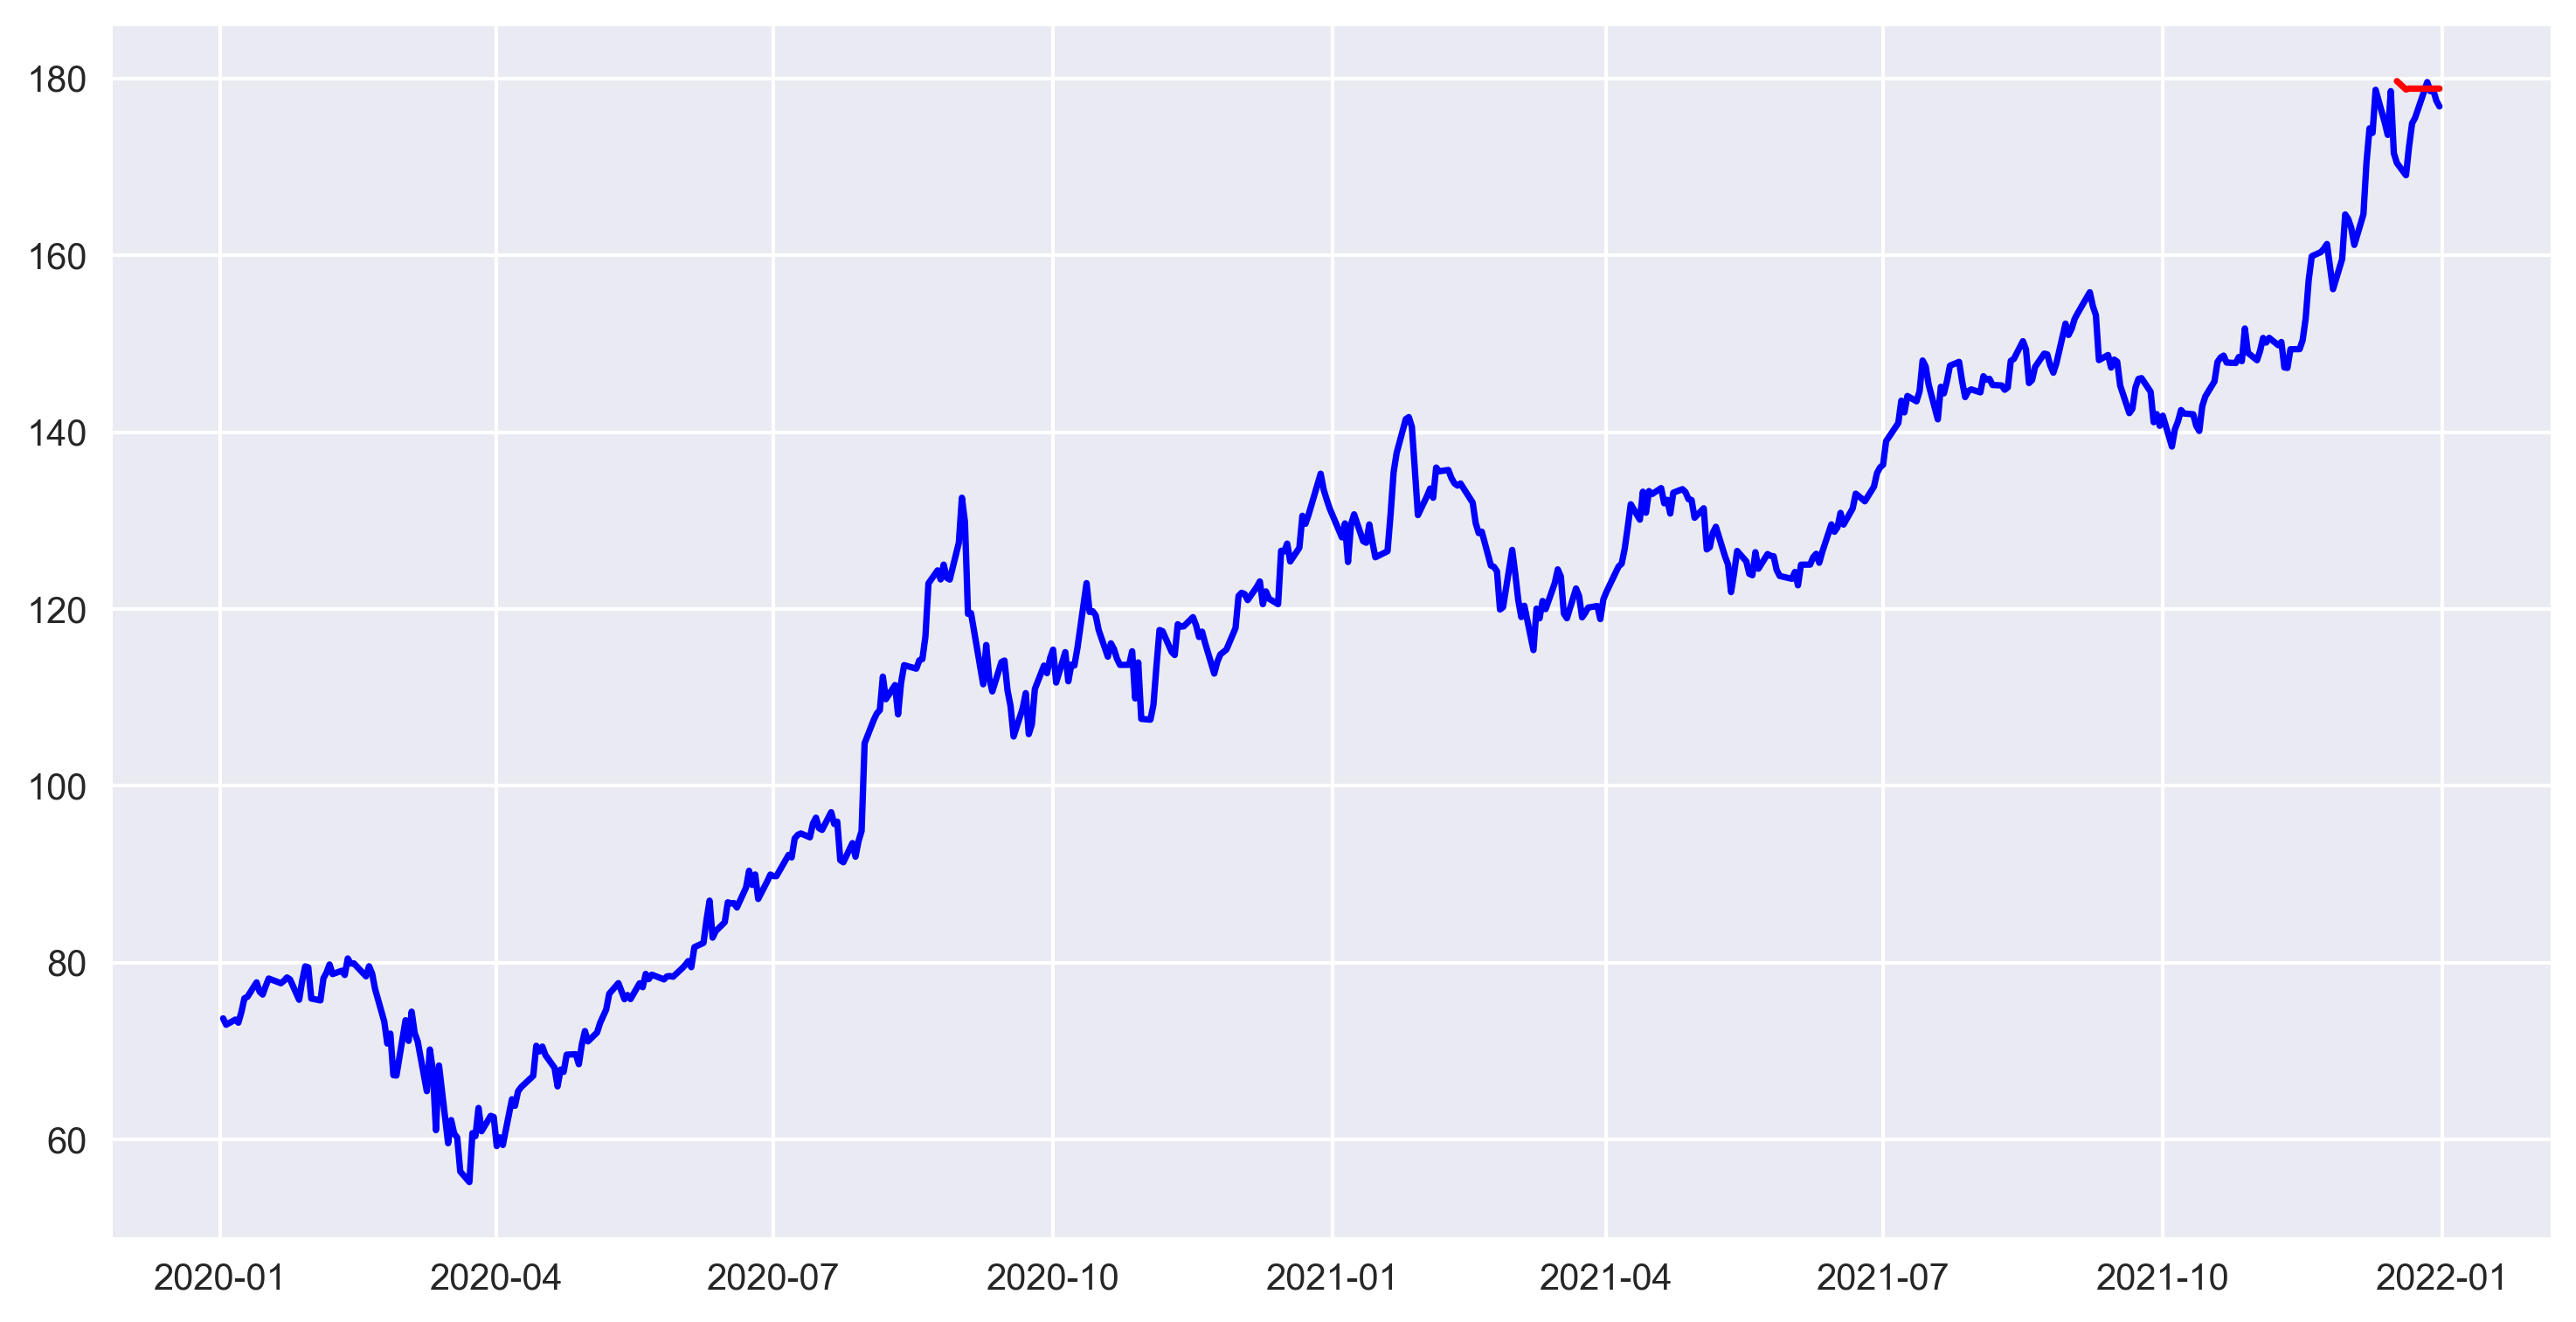

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df_yahoo['Adj Close'],color="blue")
plt.plot(df_test['pred'],color='red')

c:\Users\yangw\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


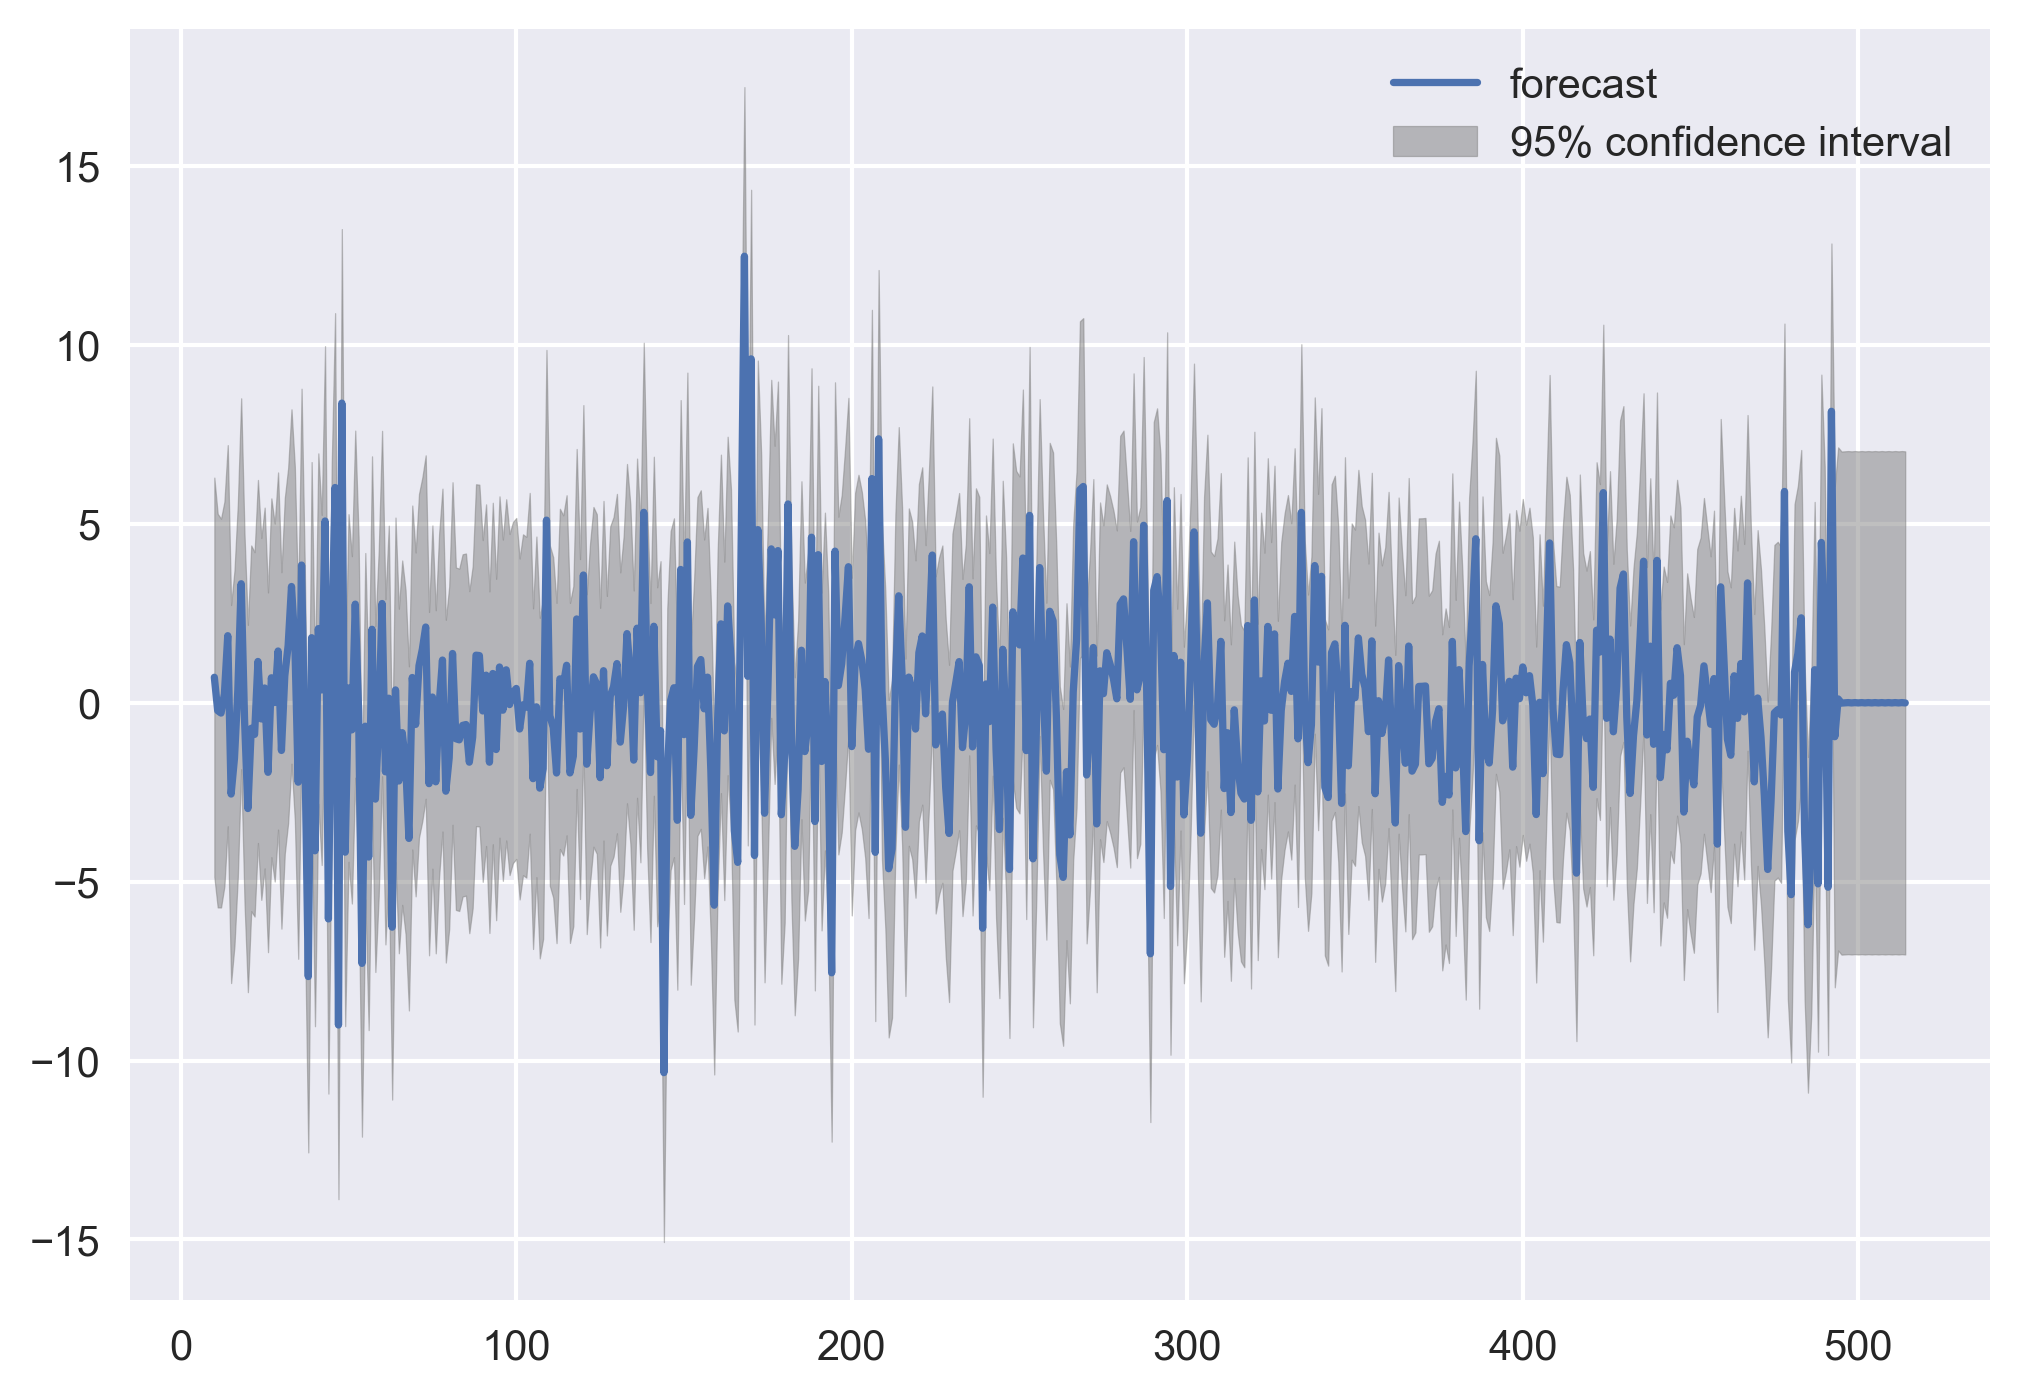

In [52]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model,10,514,)
plt.show()